# Generate model waveform

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib.pyplot import *
from numpy import *
from positive import *
from nrutils import scsearch, gwylm
from pwca import *
from glob import glob

(positive)>> Applying custom matplotlib settings.
(init)>> Warm greetings from Welsh Puck (aka pwca).
(pwca.core)>> Catalog of calibration runs stored to "pwca.pwca_catalog"
(pwca.core)>> Metadata dictionary for calibration runs stored to "pwca.metadata_dict"


In [19]:
# Display basic info about calibration runs
scsearch( catalog=pwca_catalog, keyword='q4a04t60dPm1.5D_T_96_360', verbose=True );

(scsearch)>> Found catalog (=...) keyword.
(scsearch)>> Found keyword (=q4a04t60dPm1.5D_T_96_360) keyword.
(scsearch)>> Found verbose (=True) keyword.
(scsearch)>> List of keywords or string keyword found: ALL scentry objects matching will be passed. To pass ANY entries matching the keywords, input the keywords using an iterable of not of type list.
## Found 1 possibly degenerate simulations:
[0001][hogshead] q4: 1chi0.40-p-q4.00	(q4a04t60dPm1.5D_T_96_360)



(notebook)>> CHECK PASSED: Generated physical parameters are identical to calibration ones.
>> The total time needed for the waveform is 550.526
>> The total time provided for the waveform is 2000
>> shift = 90.215476
t_start = -25.883111
>> The time domain waveform has a peak at index 3388 of 4000


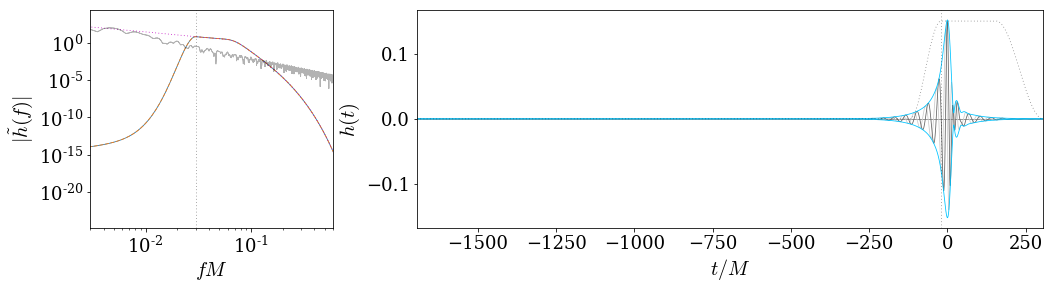

In [63]:

# Preliminaries 
# ---

# Define data location
datadir = '/Users/book/KOALA/puck/ll/data/version2/'

# Load select waveforms
files = glob( datadir+'q*.txt' )
simnames = [ f_.split('/')[-1].split('.t')[0] for f_ in files ]

# Setup plot
# ---
nrow = len(pwca_catalog)
ncol = 2
# fig,ax = subplots( nrow, ncol, figsize=3*figaspect(nrow*0.618/8) )
# ax = ax.flatten()

#
# tight_layout(1,2,10)
lw = 2

# Plot diagnostics for all calibration cases
ax_id = 0
for a in pwca_catalog:


    # Find index corresponding to chosen case
    k = simnames.index( a.simname )
    # Load data for this case
    raw_data = loadtxt(files[k]).T
    data,_,fmin,fmax,fknot = determine_data_fitting_region(raw_data)


    # Load and unpuack OPTIMAL physical parameter space -- dphi
    dphi_range = loadtxt(datadir+'fit_opt_dphase_parameters.txt')
    opt_nu4,opt_nu5,opt_nu6 = dphi_range[k,:]
    # Load and unpuack OPTIMAL physical parameter space -- amp
    amp_range = loadtxt(datadir+'fit_opt_amplitude_parameters.txt')
    opt_mu1, opt_mu2, opt_mu3, opt_mu4 = amp_range[k,:]

    # extract useful params from scentry object
    theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2,a1,a2 = select_scenty_metadata(a)
    # generate model parameters 
    mu1,mu2,mu3,mu4,nu4,nu5,nu6 = generate_model_params(theta,eta,a1)

    # generate template functions
    template_dphi = template_dphi_mrd( m1, m2, chi1, chi2, chi_p )
    
    # Load and unpuack physical parameter space
    raw_domain = loadtxt(datadir+'fit_intial_binary_parameters.txt')
    param_test_quantity = sum(raw_domain[k,:]-array([theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2,a1,a2]))==0
    if param_test_quantity:
        alert(bold(green('CHECK PASSED: '))+'Generated physical parameters are identical to calibration ones.')
    else:
        error(bold(red('CHECK PASSED: '))+'Generated physical parameters are not identical to calibration ones.')

    #
    raw_f,raw_amp_td,raw_amp_fd,raw_dphi_td,raw_dphi_fd = raw_data
    adjusted_raw_dphi_td = raw_dphi_td-min( raw_dphi_td[ (raw_f>=fmin) & (raw_f<=fmax)  ])
    f,amp_td,amp_fd,dphi_td,dphi_fd = data.T
    #
    raw_positive_mask = raw_f>0
    raw_fp = raw_f[raw_positive_mask]
    
    # -- 
    model_phi = pwca_phi_mrd( raw_fp, m1, m2, chi1, chi2, chi_p )
    
    # 
    d_model_phi = spline_diff( raw_fp, model_phi )
    adjusted_d_model_phi = d_model_phi - min(d_model_phi[(raw_fp>=fmin) & (raw_fp<=fmax)])
    
    #
    raw_f,raw_amp_td,raw_amp_fd,raw_dphi_td,raw_dphi_fd = raw_data
    adjusted_raw_dphi_td = raw_dphi_td-min( raw_dphi_td[ (raw_f>=fmin) & (raw_f<=fmax)  ])
    f,amp_td,amp_fd,dphi_td,dphi_fd = data.T

    #
    raw_positive_mask = raw_f>0
    raw_fp = raw_f[raw_positive_mask]

    #
    phenomd_dphi   = template_dphi( raw_fp )
    opt_model_dphi = template_dphi( raw_fp, opt_nu4, opt_nu5, opt_nu6 )
    model_dphi     = template_dphi( raw_fp, nu4, nu5, nu6 )
    
    #
    y = generate_pwca_waveform( raw_fp, a.m1, a.m2, a.X1, a.X2, a.L )
    full_model_phi = unwrap( -angle(y) )
    
    # 
    d_full_model_phi = spline_diff( raw_fp, full_model_phi )
    adjusted_d_full_model_phi = d_full_model_phi - min(d_full_model_phi[(raw_fp>=fmin) & (raw_fp<=fmax)])
    
    #
    ff = linspace(min(raw_fp),max(raw_fp),10000)
    y = generate_pwca_waveform( ff, a.m1, a.m2, a.X1, a.X2, a.L )
    
    #
    fstart = 0.03
    N = 4000
    model_data = ( ff, abs(y), unwrap(angle(y)) )
    dt = 0.5
    y_td,t,t_shift = phenom2td( fstart, N, dt, model_data, plot=True, verbose=True, fmax=0.3, ringdown_pad=300 )
    
    #
    break





In [12]:
print fmin

0.03466761972837741
